# Notebook Imports

In [1]:
# Import Pandas as Dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from config import protocol, username, password, host, port, database_name


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

# Connect to AWS Server

In [ ]:
# Connect to postgres database
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

# Machine Learning with First Dataframe (71,782 rows)

## Load Data

In [ ]:
# First dataframe
df1 = pd.read_sql_query('select * from food_access_1', engine)
df1.tail()

In [ ]:
# # Read df1
# df1 = pd.read_csv("first_food_access.csv", index_col=0)
# df1.head()

## Preprocessing Data

In [3]:
# Calculate population / # of households in order to create a new column
df1['Pop_per_household'] = df1['Pop2010']/df1['OHU2010']
df1.head()

,StateFIPS,CensusTract,State,County,Urban,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LAhalfand10,...,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,1,1001020100,Alabama,Autauga County,1,1912,693,11.3,81250.0,1,...,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019
1,1,1001020200,Alabama,Autauga County,1,2170,743,17.9,49000.0,1,...,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592
2,1,1001020300,Alabama,Autauga County,1,3373,1256,15.0,62609.0,1,...,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510
3,1,1001020400,Alabama,Autauga County,1,4386,1722,2.8,70607.0,1,...,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038
4,1,1001020500,Alabama,Autauga County,1,10766,4082,15.2,96334.0,1,...,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433


In [4]:
# List of columns to refer to during pre-processing and training
list(df1.columns)

['StateFIPS',
 'CensusTract',
 'State',
 'County',
 'Urban',
 'Pop2010',
 'OHU2010',
 'PovertyRate',
 'MedianFamilyIncome',
 'LAhalfand10',
 'TractLOWI',
 'TractKids',
 'TractSeniors',
 'TractWhite',
 'TractBlack',
 'TractAsian',
 'TractNHOPI',
 'TractAIAN',
 'TractOMultir',
 'TractHispanic',
 'TractHUNV',
 'TractSNAP',
 'TractLOWI_PCT',
 'TractKids_PCT',
 'TractSeniors_PCT',
 'TractWhite_PCT',
 'TractBlack_PCT',
 'TractAsian_PCT',
 'TractNHOPI_PCT',
 'TractAIAN_PCT',
 'TractOMultir_PCT',
 'TractHispanic_PCT',
 'TractHUNV_PCT',
 'TractSNAP_PCT',
 'Pop_per_household']

In [5]:
# Drop columns that don't contribute to the model
df1= df1.drop(columns = ['Pop2010', 'OHU2010', 'StateFIPS', 'CensusTract', 'State', 'County', 'Urban',
              'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
              'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP'])
df1.head()

,PovertyRate,MedianFamilyIncome,LAhalfand10,TractLOWI_PCT,TractKids_PCT,TractSeniors_PCT,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,11.3,81250.0,1,23.80,26.52,11.56,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019
1,17.9,49000.0,1,36.96,27.93,9.86,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592
2,15.0,62609.0,1,38.72,26.50,13.02,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510
3,2.8,70607.0,1,21.02,23.14,20.61,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038
4,15.2,96334.0,1,20.82,29.37,10.46,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433


In [6]:
# Move the target column to the last
cols = list(df1.columns.values)
cols.pop(cols.index('LAhalfand10')) 
df1 = df1[cols+['LAhalfand10']]
df1.head()

,PovertyRate,MedianFamilyIncome,TractLOWI_PCT,TractKids_PCT,TractSeniors_PCT,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household,LAhalfand10
0,11.3,81250.0,23.80,26.52,11.56,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019,1
1,17.9,49000.0,36.96,27.93,9.86,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592,1
2,15.0,62609.0,38.72,26.50,13.02,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510,1
3,2.8,70607.0,21.02,23.14,20.61,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038,1
4,15.2,96334.0,20.82,29.37,10.46,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433,1


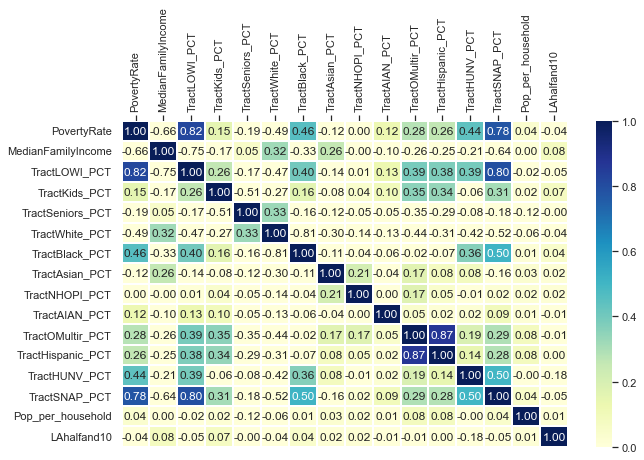

In [39]:
# Check coorelation coefficient of feature in df 
corrM = df1.corr()
  
# Create a heatmap for all parameter correlation values
sns.set(style="white",font_scale=1)
plt.figure(figsize = (10,6))
ax=sns.heatmap(corrM, cmap="YlGnBu", fmt='.2f',annot=True,\
             xticklabels=True,linewidth=2, vmin=0, vmax=1)
# Set x-axis on top and rotate for clarity
ax.xaxis.tick_top()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [7]:
# Define features and target
X = df1.drop('LAhalfand10', axis=1)
y = df1['LAhalfand10']

# Scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Testing Various Binary Classification Models: Model, Fit, Predict

In [8]:
# Create models
models = [
    LogisticRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier()
    
]


In [9]:
# Fit and Pedict models
for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)       
    print(model)
    print(f'Training Score: {model.score(X_train_scaled, y_train)}')
    print(f'Testing Score: {model.score(X_test_scaled, y_test)}')
    print()   
      

LogisticRegression()
Training Score: 0.704862917007207
Testing Score: 0.706452691407556

Lasso()
Training Score: 0.0
Testing Score: -3.8758508688729876e-05

Ridge()
Training Score: 0.062360117996025144
Testing Score: 0.06697101151080731

ElasticNet()
Training Score: 0.0
Testing Score: -3.8758508688729876e-05

KNeighborsClassifier()
Training Score: 0.8129690170146371
Testing Score: 0.7360414577064527

SVC()
Training Score: 0.7652314436436585
Testing Score: 0.7616181878970244

DecisionTreeClassifier()
Training Score: 1.0
Testing Score: 0.6826590883762398

AdaBoostClassifier()
Training Score: 0.7478267330410877
Testing Score: 0.7485233478212415

RandomForestClassifier()
Training Score: 1.0
Testing Score: 0.7773319959879639



# Model Optimization

## Feature Selection

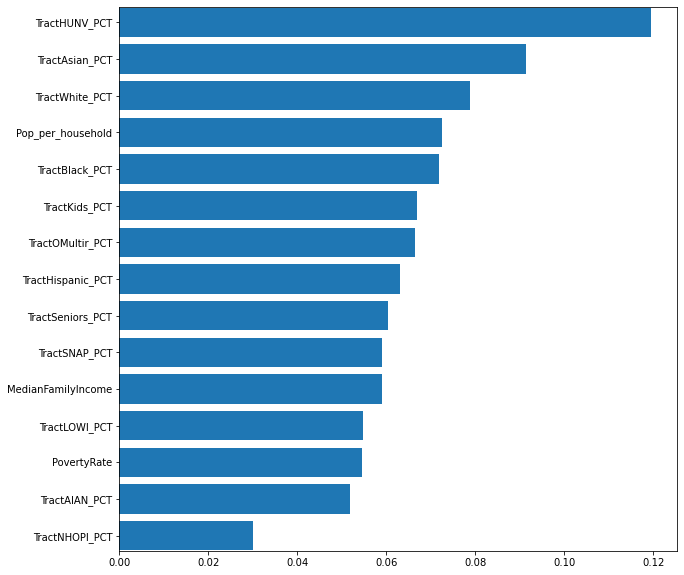

In [10]:
# Create Random Forest Classifier model
clf = RandomForestClassifier().fit(X_train_scaled, y_train)

# visualize the feature importance
feature_importances = clf.feature_importances_
# print(features)

features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
plt.margins(y=0.001)
ax.barh(y=cols, width=width)

plt.show()

In [11]:
# Select important feature for model
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

# Split train/ test data
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

# Scale the selected features
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

# Create and fit model with selected features
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_selected_train_scaled, y_train)

# Predict model
y_pred = clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

C:\Users\meena\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.66      0.49      0.56      5681
           1       0.79      0.88      0.83     12265

    accuracy                           0.76     17946
   macro avg       0.72      0.69      0.70     17946
weighted avg       0.75      0.76      0.75     17946

Training Score: 1.0
Testing Score: 0.7574947063412459


## Hyperparameter Tuning with GridSearchCV

In [12]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Create a base model
clf = RandomForestClassifier()

# Instantiate the grid search model
grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_clf.fit(X_selected_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [13]:
# List the best parameters for this dataset
print(grid_clf.best_params_)

# Predict model
y_pred = grid_clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))

print(f'Training Score: {grid_clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {grid_clf.score(X_selected_test_scaled, y_test)}')

{'max_depth': 7, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.71      0.39      0.50      5681
           1       0.77      0.92      0.84     12265

    accuracy                           0.76     17946
   macro avg       0.74      0.66      0.67     17946
weighted avg       0.75      0.76      0.73     17946

Training Score: 0.7632439259974738
Testing Score: 0.7556001337345369


# Random Forest Classifier with Second Dataframe (7,708 rows)

## Load Data

In [ ]:
# Second dataframe
df2 = pd.read_sql_query('select * from food_access_2', engine)
df2.tail()

In [14]:
# Read df2
df2 = pd.read_csv("second_food_access.csv", index_col=0)
df2.head()

,StateFIPS,CensusTract,State,County,Urban,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LAhalfand10,...,TractSeniors_PCT,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT
0,1,1001020801,Alabama,Autauga County,0,3081,1074,8.9,89423.0,0,...,11.07,87.31,9.02,0.52,0.00,0.88,2.27,1.85,6.33,13.31
1,1,1001020802,Alabama,Autauga County,0,10435,3694,13.7,84833.0,0,...,10.16,83.79,13.29,0.58,0.07,0.47,1.79,1.52,5.36,9.53
2,1,1001020900,Alabama,Autauga County,0,5675,2067,9.8,77865.0,0,...,11.10,85.20,11.96,0.35,0.05,0.25,2.19,1.69,4.69,16.45
3,1,1001021000,Alabama,Autauga County,0,2894,1085,22.7,60900.0,1,...,11.99,76.81,20.84,0.10,0.00,0.62,1.62,1.35,0.83,13.46
4,1,1001021100,Alabama,Autauga County,0,3320,1306,24.1,49833.0,1,...,14.85,43.40,54.52,0.06,0.00,0.42,1.60,1.17,20.60,17.61


# Preprocess Data

In [15]:
# Calculate population / # of households in order to create a new column
df2['Pop_per_household'] = df2['Pop2010']/df2['OHU2010']
df2.head()

,StateFIPS,CensusTract,State,County,Urban,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LAhalfand10,...,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,1,1001020801,Alabama,Autauga County,0,3081,1074,8.9,89423.0,0,...,87.31,9.02,0.52,0.00,0.88,2.27,1.85,6.33,13.31,2.868715
1,1,1001020802,Alabama,Autauga County,0,10435,3694,13.7,84833.0,0,...,83.79,13.29,0.58,0.07,0.47,1.79,1.52,5.36,9.53,2.824851
2,1,1001020900,Alabama,Autauga County,0,5675,2067,9.8,77865.0,0,...,85.20,11.96,0.35,0.05,0.25,2.19,1.69,4.69,16.45,2.745525
3,1,1001021000,Alabama,Autauga County,0,2894,1085,22.7,60900.0,1,...,76.81,20.84,0.10,0.00,0.62,1.62,1.35,0.83,13.46,2.667281
4,1,1001021100,Alabama,Autauga County,0,3320,1306,24.1,49833.0,1,...,43.40,54.52,0.06,0.00,0.42,1.60,1.17,20.60,17.61,2.542113


In [16]:
# List of columns to refer to during pre-processing and training
list(df2.columns)

['StateFIPS',
 'CensusTract',
 'State',
 'County',
 'Urban',
 'Pop2010',
 'OHU2010',
 'PovertyRate',
 'MedianFamilyIncome',
 'LAhalfand10',
 'lapophalfshare',
 'lalowihalfshare',
 'lakidshalfshare',
 'laseniorshalfshare',
 'lawhitehalfshare',
 'lablackhalfshare',
 'laasianhalfshare',
 'lanhopihalfshare',
 'laaianhalfshare',
 'laomultirhalfshare',
 'lahisphalfshare',
 'lahunvhalfshare',
 'lasnaphalfshare',
 'lapop10share',
 'lalowi10share',
 'lakids10share',
 'laseniors10share',
 'lawhite10share',
 'lablack10share',
 'laasian10share',
 'lanhopi10share',
 'laaian10share',
 'laomultir10share',
 'lahisp10share',
 'lahunv10share',
 'lasnap10share',
 'TractLOWI',
 'TractKids',
 'TractSeniors',
 'TractWhite',
 'TractBlack',
 'TractAsian',
 'TractNHOPI',
 'TractAIAN',
 'TractOMultir',
 'TractHispanic',
 'TractHUNV',
 'TractSNAP',
 'TractLOWI_PCT',
 'TractKids_PCT',
 'TractSeniors_PCT',
 'TractWhite_PCT',
 'TractBlack_PCT',
 'TractAsian_PCT',
 'TractNHOPI_PCT',
 'TractAIAN_PCT',
 'TractOMultir_

In [17]:
# Drop columns that don't contribute to the model
df2= df2.drop(columns = ['Pop2010', 'OHU2010', 'StateFIPS', 'CensusTract', 'State', 'County', 'Urban',
              'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
              'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP'])
df2.head()

,PovertyRate,MedianFamilyIncome,LAhalfand10,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,...,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,8.9,89423.0,0,100.00,18.70,26.45,11.07,87.31,9.02,0.52,...,87.31,9.02,0.52,0.00,0.88,2.27,1.85,6.33,13.31,2.868715
1,13.7,84833.0,0,99.00,26.67,27.63,10.06,82.85,13.25,0.58,...,83.79,13.29,0.58,0.07,0.47,1.79,1.52,5.36,9.53,2.824851
2,9.8,77865.0,0,97.79,23.42,26.04,10.86,83.16,11.95,0.34,...,85.20,11.96,0.35,0.05,0.25,2.19,1.69,4.69,16.45,2.745525
3,22.7,60900.0,1,100.00,38.67,25.92,11.99,76.81,20.84,0.10,...,76.81,20.84,0.10,0.00,0.62,1.62,1.35,0.83,13.46,2.667281
4,24.1,49833.0,1,100.00,51.75,22.59,14.85,43.40,54.52,0.06,...,43.40,54.52,0.06,0.00,0.42,1.60,1.17,20.60,17.61,2.542113


In [18]:
# Move the target column to the last
cols = list(df2.columns.values)
cols.pop(cols.index('LAhalfand10')) 
df2 = df2[cols+['LAhalfand10']]
df2.head()

,PovertyRate,MedianFamilyIncome,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,lanhopihalfshare,...,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household,LAhalfand10
0,8.9,89423.0,100.00,18.70,26.45,11.07,87.31,9.02,0.52,0.00,...,9.02,0.52,0.00,0.88,2.27,1.85,6.33,13.31,2.868715,0
1,13.7,84833.0,99.00,26.67,27.63,10.06,82.85,13.25,0.58,0.07,...,13.29,0.58,0.07,0.47,1.79,1.52,5.36,9.53,2.824851,0
2,9.8,77865.0,97.79,23.42,26.04,10.86,83.16,11.95,0.34,0.05,...,11.96,0.35,0.05,0.25,2.19,1.69,4.69,16.45,2.745525,0
3,22.7,60900.0,100.00,38.67,25.92,11.99,76.81,20.84,0.10,0.00,...,20.84,0.10,0.00,0.62,1.62,1.35,0.83,13.46,2.667281,1
4,24.1,49833.0,100.00,51.75,22.59,14.85,43.40,54.52,0.06,0.00,...,54.52,0.06,0.00,0.42,1.60,1.17,20.60,17.61,2.542113,1


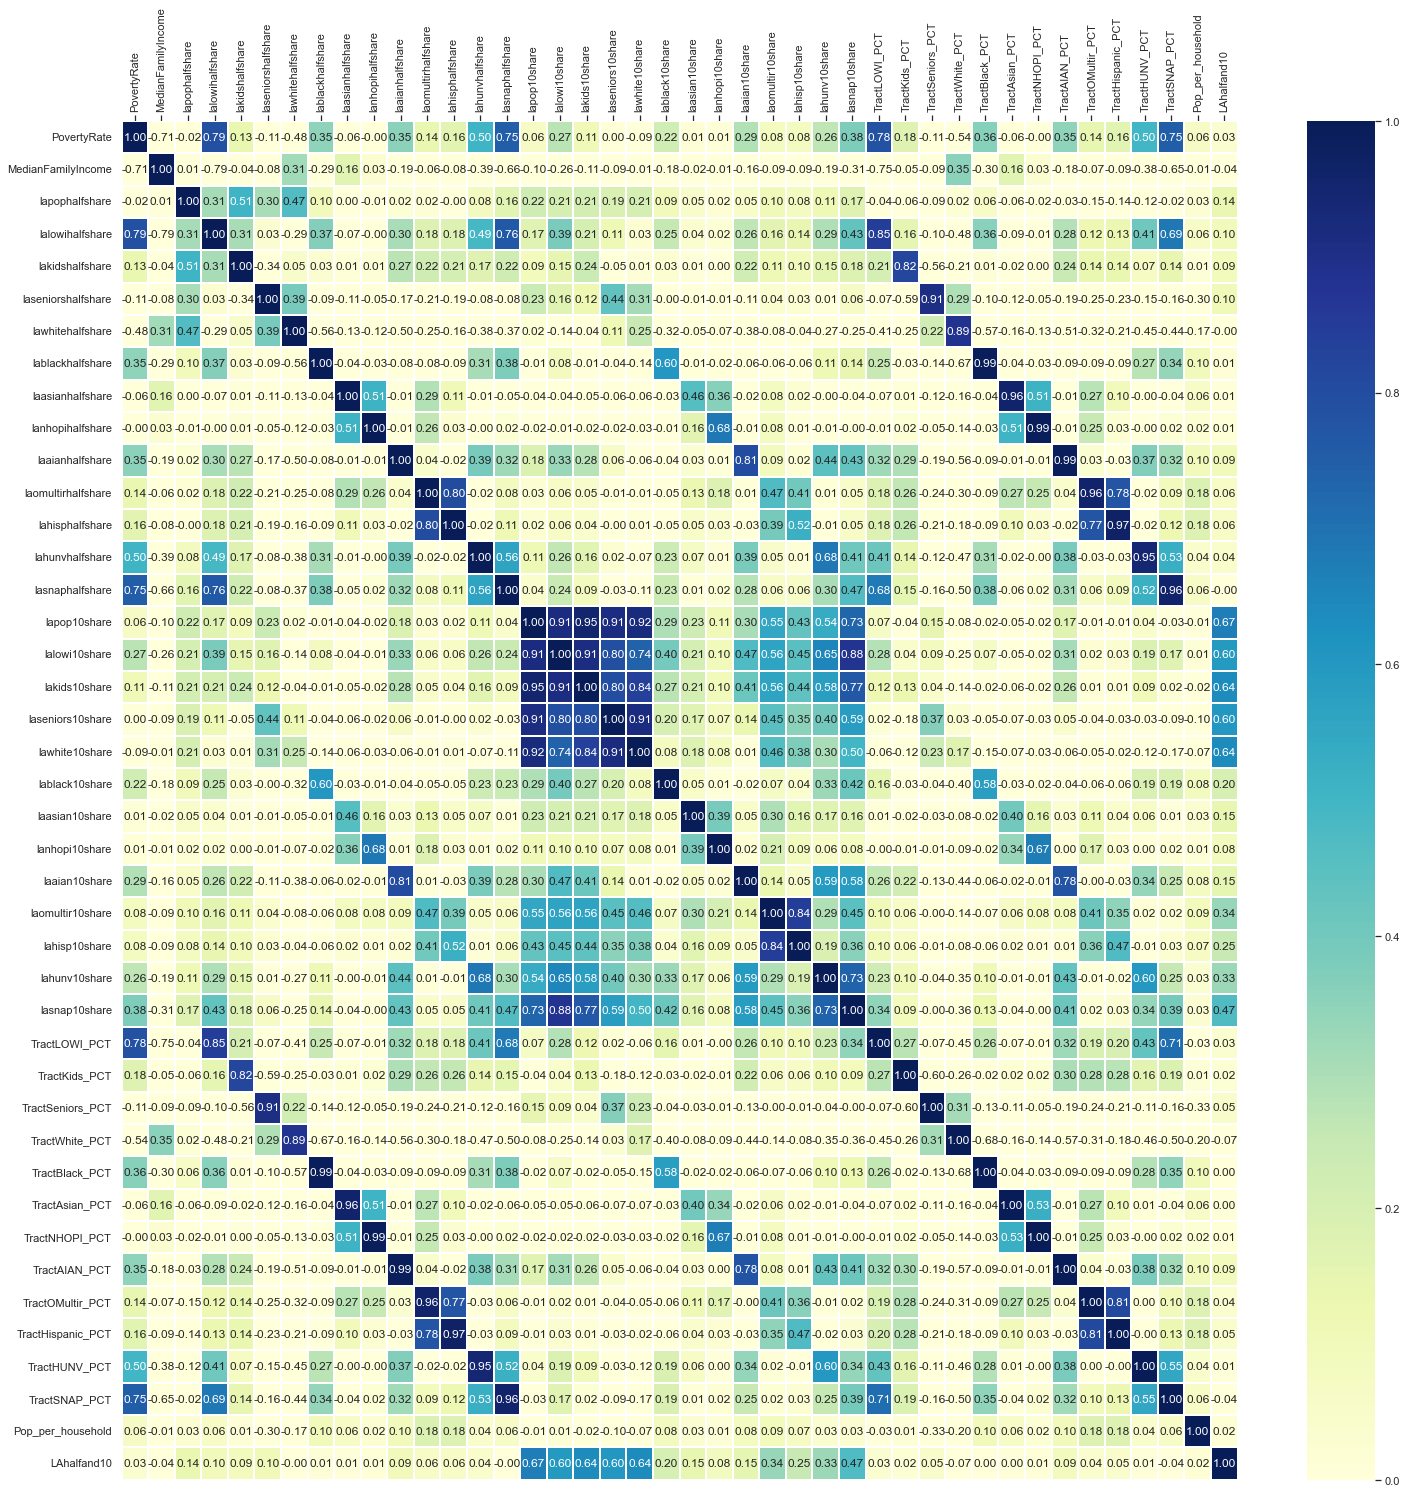

In [46]:
# Check coorelation coefficient of feature in df 
corrM = df2.corr()
  
# Create a heatmap for all parameter correlation values
sns.set(style="white",font_scale=1)
plt.figure(figsize = (25,25))
ax=sns.heatmap(corrM, cmap="YlGnBu", fmt='.2f',annot=True,\
             xticklabels=True,linewidth=2, vmin=0, vmax=1)
# Set x-axis on top and rotate for clarity
ax.xaxis.tick_top()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [19]:
# Define features and target
X = df2.drop('LAhalfand10', axis=1)
y = df2['LAhalfand10']

# Scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Optimization

## Feature Selection

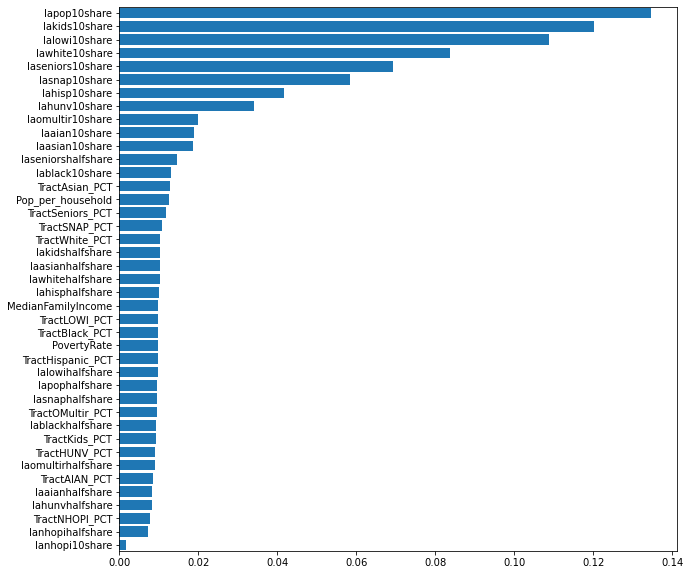

In [20]:
# Create Random Forest Classifier model
clf = RandomForestClassifier().fit(X_train_scaled, y_train)

# visualize the feature importance
feature_importances = clf.feature_importances_
# print(features)

features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
plt.margins(y=0.001)
ax.barh(y=cols, width=width)

plt.show()

In [21]:
# Select important feature for model
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

# Split train/ test data
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

# Scale the selected features
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

# Create and fit model with selected features
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_selected_train_scaled, y_train)

# Predict model
y_pred = clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

C:\Users\meena\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1000
           1       0.91      0.86      0.89       927

    accuracy                           0.89      1927
   macro avg       0.90      0.89      0.89      1927
weighted avg       0.90      0.89      0.89      1927

Training Score: 0.984604739664418
Testing Score: 0.8946549039958485


## Hyperparameter Tuning with GridSearchCV

In [22]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200]
}

# Create a base model
clf = RandomForestClassifier()

# Instantiate the grid search model
grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_clf.fit(X_selected_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [23]:
# List the best parameters for this dataset
print(grid_clf.best_params_)

# Predict model
y_pred = grid_clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))

print(f'Training Score: {grid_clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {grid_clf.score(X_selected_test_scaled, y_test)}')


{'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1000
           1       0.92      0.86      0.89       927

    accuracy                           0.90      1927
   macro avg       0.90      0.90      0.90      1927
weighted avg       0.90      0.90      0.90      1927

Training Score: 0.895000864902266
Testing Score: 0.8962117280747276


# Random Forest Classifier with Third DataFrame (67,286 rows)

## Load Data

In [1]:
# Third dataframe
df3 = pd.read_sql_query('select * from food_access_3', engine)
df3.tail()

In [24]:
# # Read df3
# df3 = pd.read_csv("third_food_access.csv", index_col=0)
# df3.head()

,StateFIPS,CensusTract,State,County,Urban,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LAhalfand10,...,TractSeniors_PCT,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT
0,1,1001020100,Alabama,Autauga County,1,1912,693,11.3,81250.0,1,...,11.56,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72
1,1,1001020200,Alabama,Autauga County,1,2170,743,17.9,49000.0,1,...,9.86,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00
2,1,1001020300,Alabama,Autauga County,1,3373,1256,15.0,62609.0,1,...,13.02,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69
3,1,1001020400,Alabama,Autauga County,1,4386,1722,2.8,70607.0,1,...,20.61,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69
4,1,1001020500,Alabama,Autauga County,1,10766,4082,15.2,96334.0,1,...,10.46,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30


## Preprocess Data

In [25]:
# Calculate population / # of households in order to create a new column
df3['Pop_per_household'] = df3['Pop2010']/df3['OHU2010']
df3.head()

,StateFIPS,CensusTract,State,County,Urban,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LAhalfand10,...,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,1,1001020100,Alabama,Autauga County,1,1912,693,11.3,81250.0,1,...,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019
1,1,1001020200,Alabama,Autauga County,1,2170,743,17.9,49000.0,1,...,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592
2,1,1001020300,Alabama,Autauga County,1,3373,1256,15.0,62609.0,1,...,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510
3,1,1001020400,Alabama,Autauga County,1,4386,1722,2.8,70607.0,1,...,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038
4,1,1001020500,Alabama,Autauga County,1,10766,4082,15.2,96334.0,1,...,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433


In [26]:
# List of columns to refer to during pre-processing and training
list(df3.columns)

['StateFIPS',
 'CensusTract',
 'State',
 'County',
 'Urban',
 'Pop2010',
 'OHU2010',
 'PovertyRate',
 'MedianFamilyIncome',
 'LAhalfand10',
 'lapophalfshare',
 'lalowihalfshare',
 'lakidshalfshare',
 'laseniorshalfshare',
 'lawhitehalfshare',
 'lablackhalfshare',
 'laasianhalfshare',
 'lanhopihalfshare',
 'laaianhalfshare',
 'laomultirhalfshare',
 'lahisphalfshare',
 'lahunvhalfshare',
 'lasnaphalfshare',
 'TractLOWI',
 'TractKids',
 'TractSeniors',
 'TractWhite',
 'TractBlack',
 'TractAsian',
 'TractNHOPI',
 'TractAIAN',
 'TractOMultir',
 'TractHispanic',
 'TractHUNV',
 'TractSNAP',
 'TractLOWI_PCT',
 'TractKids_PCT',
 'TractSeniors_PCT',
 'TractWhite_PCT',
 'TractBlack_PCT',
 'TractAsian_PCT',
 'TractNHOPI_PCT',
 'TractAIAN_PCT',
 'TractOMultir_PCT',
 'TractHispanic_PCT',
 'TractHUNV_PCT',
 'TractSNAP_PCT',
 'Pop_per_household']

In [27]:
# Drop columns that don't contribute to the model
df3= df3.drop(columns = ['Pop2010', 'OHU2010', 'StateFIPS', 'CensusTract', 'State', 'County', 'Urban',
              'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
              'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP'])
df3.head()

,PovertyRate,MedianFamilyIncome,LAhalfand10,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,...,TractWhite_PCT,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household
0,11.3,81250.0,1,100.00,24.42,26.52,11.56,84.83,11.35,0.73,...,84.83,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019
1,17.9,49000.0,1,100.00,44.34,27.93,9.86,40.92,56.08,0.23,...,40.92,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592
2,15.0,62609.0,1,84.70,28.79,22.86,10.60,64.53,16.43,0.30,...,76.37,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510
3,2.8,70607.0,1,83.24,20.36,19.30,17.48,77.41,3.88,0.34,...,93.16,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038
4,15.2,96334.0,1,72.25,15.97,21.45,7.80,58.51,9.29,1.94,...,80.49,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433


In [28]:
# Move the target column to the last
cols = list(df3.columns.values)
cols.pop(cols.index('LAhalfand10')) 
df3 = df3[cols+['LAhalfand10']]
df3.head()

,PovertyRate,MedianFamilyIncome,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,lanhopihalfshare,...,TractBlack_PCT,TractAsian_PCT,TractNHOPI_PCT,TractAIAN_PCT,TractOMultir_PCT,TractHispanic_PCT,TractHUNV_PCT,TractSNAP_PCT,Pop_per_household,LAhalfand10
0,11.3,81250.0,100.00,24.42,26.52,11.56,84.83,11.35,0.73,0.00,...,11.35,0.73,0.00,0.73,2.35,2.30,0.87,14.72,2.759019,1
1,17.9,49000.0,100.00,44.34,27.93,9.86,40.92,56.08,0.23,0.00,...,56.08,0.23,0.00,0.23,2.53,3.46,11.98,21.00,2.920592,1
2,15.0,62609.0,84.70,28.79,22.86,10.60,64.53,16.43,0.30,0.03,...,19.18,0.50,0.15,0.33,3.47,2.58,7.88,13.69,2.685510,1
3,2.8,70607.0,83.24,20.36,19.30,17.48,77.41,3.88,0.34,0.06,...,4.40,0.41,0.09,0.25,1.69,1.94,1.22,5.69,2.547038,1
4,15.2,96334.0,72.25,15.97,21.45,7.80,58.51,9.29,1.94,0.05,...,13.35,2.75,0.08,0.45,2.88,3.30,5.63,8.30,2.637433,1


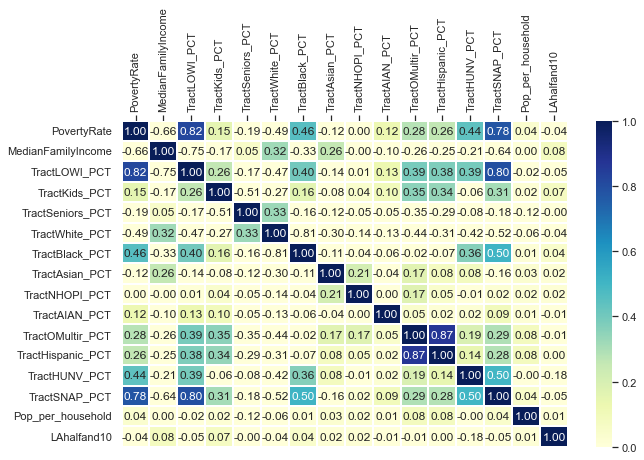

In [45]:
# Check coorelation coefficient of feature in df 
corrM = df1.corr()
  
# Create a heatmap for all parameter correlation values
sns.set(style="white",font_scale=1)
plt.figure(figsize = (10,6))
ax=sns.heatmap(corrM, cmap="YlGnBu", fmt='.2f',annot=True,\
             xticklabels=True,linewidth=2, vmin=0, vmax=1)
# Set x-axis on top and rotate for clarity
ax.xaxis.tick_top()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [29]:
# Define features and target
X = df3.drop('LAhalfand10', axis=1)
y = df3['LAhalfand10']

# Scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model, Fit, Predict 

In [30]:
clf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled) 

print(classification_report(y_test, y_pred))
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      4620
           1       0.87      0.92      0.90     12202

    accuracy                           0.85     16822
   macro avg       0.81      0.78      0.80     16822
weighted avg       0.84      0.85      0.84     16822

Training Score: 1.0
Testing Score: 0.8452621566995601


# Model Optimization

## Feature Selection

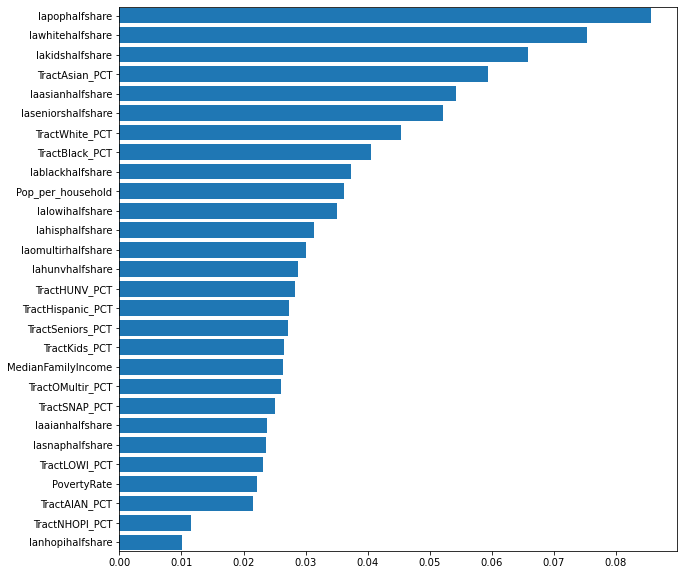

In [31]:
# visualize the feature importance
feature_importances = clf.feature_importances_
# print(features)

features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
plt.margins(y=0.001)
ax.barh(y=cols, width=width)

plt.show()

In [32]:
# Select important feature for model
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

# Split train/ test data
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

# Scale the selected features
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

# Create and fit model with selected features
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_selected_train_scaled, y_train)

# Predict model
y_pred = clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

C:\Users\meena\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.63      0.68      4615
           1       0.87      0.92      0.89     12207

    accuracy                           0.84     16822
   macro avg       0.81      0.78      0.79     16822
weighted avg       0.83      0.84      0.84     16822

Training Score: 0.9999801838934687
Testing Score: 0.8391986684104149


## Hyperparameter Tuning with GridSearchCV

In [37]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Create a base model
clf = RandomForestClassifier()

# Instantiate the grid search model
grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_clf.fit(X_selected_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [38]:
# List the best parameters for this dataset
print(grid_clf.best_params_)

# Predict model
y_pred = grid_clf.predict(X_selected_test_scaled)

# Display score
print(classification_report(y_test, y_pred))

print(f'Training Score: {grid_clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {grid_clf.score(X_selected_test_scaled, y_test)}')

{'max_depth': 7, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      4615
           1       0.85      0.93      0.88     12207

    accuracy                           0.82     16822
   macro avg       0.79      0.74      0.76     16822
weighted avg       0.82      0.82      0.82     16822

Training Score: 0.8333267279644896
Testing Score: 0.8236832719058376
